In [1]:
import numpy as np
import sklearn
import sklearn.linear_model as sk_linear
import matplotlib.pyplot as plt
from scipy.stats import norm


## Problem 1 Code

In [2]:
def load_data():
    # Label 0 are pullovers, label 1 are coats
    # X matrices are shape (num samples, num pixels)
    data = np.load("p3f_data.npy", allow_pickle=True).item()
    X_train = data["X_train"] # (1500, 784)
    X_val = data["X_val"]     # (1400, 784)
    X_test = data["X_test"]   # (700, 784)
    y_train = data["y_train"] # (1500,)
    y_val = data["y_val"]     # (1400,)
    y_test = data["y_test"]   # (700,)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
def prediction_metrics(y_true, y_pred):
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    prec = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    return acc, f1, prec, recall

In [4]:
def EM_adjust_posterior(classifier, X_train, y_train, train_prior, X_val):
    # classifier is an sklearn.linear_model.LogisticRegression class
    # TODO: complete this function for estimating class priors after
    # the label shift. 
    # X_val contains sample feature vectors from after the shift.
    # Hint: the method LogisticRegression.predict_proba()
    # may be useful.
    pred_prob = classifier.predict_proba(X_val)
    new_prior = train_prior.copy()

    for t in range(100):
        prob = []
        for i in range(X_val.shape[0]):
            prob_1 = ((new_prior[1]/train_prior[1]) * pred_prob[i][1]) / ((new_prior[0]/train_prior[0]) * pred_prob[i][0] + (new_prior[1]/train_prior[1]) * pred_prob[i][1])
            prob.append(prob_1)
            
        new_prior[1] = sum(prob)/len(prob)
        new_prior[0] = 1 - new_prior[1]
        
    return new_prior

In [5]:
def update_predictions(classifier, train_prior, new_prior, X_test):
    # TODO: complete this function for updating the predictions
    # on X_test using new_prior, an estimate of the after-shift priors.
    # This function should return class predictions, not class probabilities.

    # default return so code runs
    pred_origin_prob = classifier.predict_proba(X_test)
    after_prob = []
    for i in range(X_test.shape[0]):
        prob_1 = ((new_prior[1]/train_prior[1]) * pred_origin_prob[i][1]) / ((new_prior[0]/train_prior[0]) * pred_origin_prob[i][0] + (new_prior[1]/train_prior[1]) * pred_origin_prob[i][1])
        after_prob.append(prob_1)

    predicted_labels = [1 if prob >= 0.5 else 0 for prob in after_prob]

    return np.array(predicted_labels)

In [6]:
if __name__ == "__main__":
    X_train, X_val, X_test, y_train, y_val, y_test = load_data()

    classifier = sk_linear.LogisticRegression(max_iter=500)
    classifier.fit(X_train, y_train)

    pi0 = (y_train == 0).mean()
    pi1 = (y_train == 1).mean()
    train_prior = np.asarray([pi0, pi1])

    y_pred_unadjust = classifier.predict(X_test)
    acc, f1, prec, recall = prediction_metrics(y_test, y_pred_unadjust)
    print(f"Unadjusted LR: Accuracy: {acc:.2f}, F1-score: {f1:.2f}, Precision: {prec:.2f}, Recall: {recall:.2f}")

    EM_prior = EM_adjust_posterior(classifier, X_train, y_train, train_prior, X_val)
    y_pred_EM = update_predictions(classifier, train_prior, EM_prior, X_test)

    acc, f1, prec, recall = prediction_metrics(y_test, y_pred_EM)
    print(f"EM-adjusted LR: Accuracy: {acc:.2f}, F1-score: {f1:.2f}, Precision: {prec:.2f}, Recall: {recall:.2f}")

    test_ML_priors = np.asarray([(y_test==0).mean(), (y_test==1).mean()])
    y_pred_ML = update_predictions(classifier, train_prior, test_ML_priors, X_test) 

    acc, f1, prec, recall = prediction_metrics(y_test, y_pred_ML)
    print(f"CLairvoyant (ML) adjusted LR: Accuracy: {acc:.2f}, F1-score: {f1:.2f}, Precision: {prec:.2f}, Recall: {recall:.2f}")

Unadjusted LR: Accuracy: 0.83, F1-score: 0.59, Precision: 0.46, Recall: 0.85
EM-adjusted LR: Accuracy: 0.90, F1-score: 0.65, Precision: 0.65, Recall: 0.64
CLairvoyant (ML) adjusted LR: Accuracy: 0.90, F1-score: 0.63, Precision: 0.65, Recall: 0.60


## Problem 3

### (a)

In [2]:
## define the true function
def true_fun(x):
    values = []
    for i in range(len(x)):
        y = np.sin(2 * np.pi * x[i]) + np.sin(11 * np.pi * x[i])
        values.append(y)
    
    return values


In [3]:
x_train = [0.2, 0.35, 0.5, 0.6, 0.75]
y_train = true_fun(x_train)
y_train

[1.5388417685876266,
 0.35502649463539787,
 -0.9999999999999999,
 0.36327126400268195,
 -0.2928932188134551]

In [4]:
## Now I need to define the kernel matrix 
def gaussian_kernel_matrix(x1, x2, sigma_k, gamma):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i, j] = sigma_k**2 * np.exp(-gamma * (x1[i] - x2[j]) ** 2)
        
    return K

In [5]:
K_train = gaussian_kernel_matrix(x_train, x_train, sigma_k = 0.9, gamma = 200)
K_train

array([[8.10000000e-01, 8.99828720e-03, 1.23362836e-08, 1.02579741e-14,
        4.30198472e-27],
       [8.99828720e-03, 8.10000000e-01, 8.99828720e-03, 3.01858907e-06,
        1.02579741e-14],
       [1.23362836e-08, 8.99828720e-03, 8.10000000e-01, 1.09621579e-01,
        3.01858907e-06],
       [1.02579741e-14, 3.01858907e-06, 1.09621579e-01, 8.10000000e-01,
        8.99828720e-03],
       [4.30198472e-27, 1.02579741e-14, 3.01858907e-06, 8.99828720e-03,
        8.10000000e-01]])

In [6]:
def sigma_eI(sigma_e, row_num, col_num):
    I = np.eye(row_num)
    return sigma_e ** 2 * I

In [7]:
row_num_K, col_num_K = K_train.shape

In [8]:
sigma_eI_train = sigma_eI(1e-10, row_num_K, col_num_K)

Now I am going to construct a sequence of x's 

In [87]:
x_points = np.linspace(0, 1, 15000)
y_points = true_fun(x_points)

Text(0.5, 1.0, 'plot of y versus x')

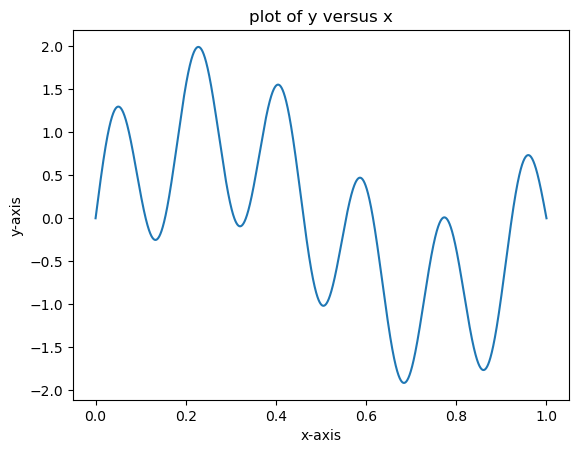

In [88]:
## first visualize y versus x
plt.plot(x_points, y_points)
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("plot of y versus x")

I will first compute the posterior mean function

In [89]:
x_1 = gaussian_kernel_matrix([x_points[0]], x_train, 0.9, 200)

In [90]:
def compute_mean_posterior(x, x_train, y_train):
    posterior_mean = []
    for i in range(len(x)):
        k_x = gaussian_kernel_matrix([x[i]], x_train, 0.9, 200)
        inv_K_sigma_e_I = np.linalg.inv(K_train + sigma_eI_train)
        f_x = np.dot(k_x, np.dot(inv_K_sigma_e_I, y_train))

        posterior_mean.append(f_x.item(0))
    
    return posterior_mean

In [91]:
def compute_band_sigma(x, x_train):
    sigma_x = []
    for i in range(len(x)):
        k_xx = 0.9**2 * np.exp(- 200 * (x[i] - x[i]) ** 2)
        k_x = gaussian_kernel_matrix([x[i]], x_train, 0.9, 200)
        inv_K_sigma_e_I = np.linalg.inv(K_train + sigma_eI_train)
        value = k_xx - np.dot(k_x, np.dot(inv_K_sigma_e_I, k_x.T))

        sigma_x.append(np.sqrt(value.item(0)))

    return sigma_x


In [92]:
x_posterior_mean = compute_mean_posterior(x_points, x_train, y_train)
x_band_sigma = compute_band_sigma(x_points, x_train)

In [93]:
### define the upper band
upper_band = np.array(x_posterior_mean) + 2 * np.array(x_band_sigma)
upper_band = upper_band.tolist()

### define the lower band
lower_band = np.array(x_posterior_mean) - 2 * np.array(x_band_sigma)
lower_band = lower_band.tolist()

In [94]:
max(upper_band)

2.3925129058814223

We can now start the drawing

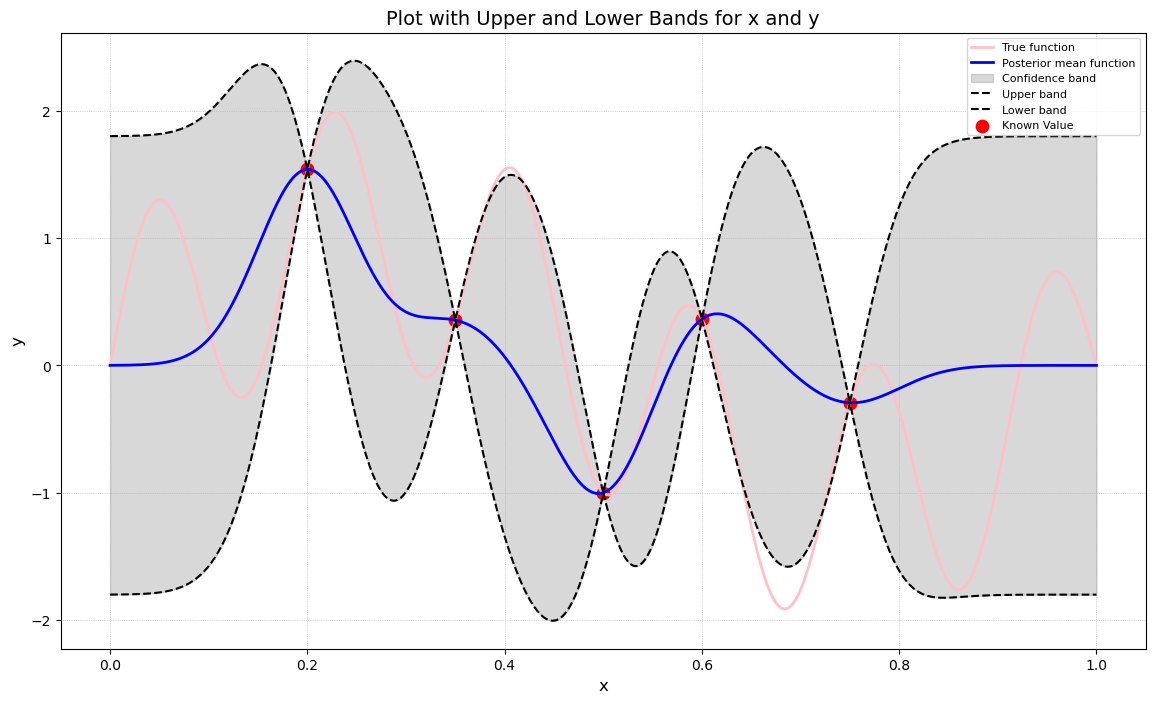

In [95]:
plt.figure(figsize=(14, 8))
plt.plot(x_points, y_points, color="pink", linestyle="-", linewidth=2, label="True function")

# Plot the posterior mean function
plt.plot(x_points, x_posterior_mean, color="blue", linestyle="-", linewidth=2, label="Posterior mean function")

# Plot the confidence band as a filled area between upper and lower bands
plt.fill_between(x_points, lower_band, upper_band, color="gray", alpha=0.3, label="Confidence band")

# Plot the upper and lower band lines
plt.plot(x_points, upper_band, color="black", linestyle="--", linewidth=1.5, label="Upper band")
plt.plot(x_points, lower_band, color="black", linestyle="--", linewidth=1.5, label="Lower band")

plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Plot with Upper and Lower Bands for x and y", fontsize=14)

plt.scatter(x_train, y_train, color = "red", marker = "o", s = 80, label = "Known Value")

plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.legend(loc="best", fontsize=8)

plt.show()

### (b)

In [96]:
max_ucb_index = upper_band.index(max(upper_band))
x_ucb_next = x_points[max_ucb_index]

In [97]:
### Get the next value of x going to evalutate the function
print("The next value of x going to evaluate the function is:", x_ucb_next)

The next value of x going to evaluate the function is: 0.2474831655443696


In [99]:
y_ucb_next = y_points[max_ucb_index]
print("The next value of y_ucb_next is:", y_ucb_next)


The next value of y_ucb_next is: 1.7657323843674873


Thus, the next value of x we are going to evaluate the function is 0.2474.

### (c)

In [100]:
max_pi_index = x_posterior_mean.index(max(x_posterior_mean))
x_star = x_points[max_pi_index]
print("The point with highest function value is:", x_star)

The point with highest function value is: 0.20041336089072603


In [104]:
max_pi_index

3006

In [105]:
### Determine the point that with highest probability of f(x) will exceed f(x*)
def PI_method(list_x, x_posterior_mean_list, x_band_sigma_list):

    f_x_star = max(x_posterior_mean_list)
    
    # Calculate PI for each point in list_x
    prob_exceed_x_star = []
    for i in range(len(list_x)):
        # Calculate the probability of improvement
        prob_exceed = 1 - norm.cdf((f_x_star - x_posterior_mean_list[i]) / x_band_sigma_list[i])
        prob_exceed_x_star.append(prob_exceed)
    
    # Find the index of the point with the highest PI value
    max_pi_index_after = prob_exceed_x_star.index(max(prob_exceed_x_star))
    
    return list_x[max_pi_index_after], max_pi_index_after
    

In [109]:
x_pi_next, index  = PI_method(x_points, x_posterior_mean, x_band_sigma)
print("The point with highest probability of f(x) will exceed f(x*) using PI method is :", x_pi_next)

The point with highest probability of f(x) will exceed f(x*) using PI method is : 0.20041336089072603


In [110]:
y_pi_next = y_points[index]
print("The next value of y_ucb_next is:", y_pi_next)

The next value of y_ucb_next is: 1.5511373710809984


### (d)

I will use sampling method to simulate the EI, that I will not get a precise formula for calculating EI

In [117]:
def EI_method(list_x, x_posterior_mean_list, x_band_sigma_list):

    f_x_star = max(x_posterior_mean_list)
    
    EI_exceed_x_star = []
    for i in range(len(list_x)):
        mean_x = x_posterior_mean_list[i] - f_x_star
        sigma_x = x_band_sigma_list[i]
        ### sampling from the distribution
        samples = np.random.normal(loc = mean_x, scale= sigma_x, size = 20000).tolist()
        ### calculate E(max(0, f(x) - f(x_star)))
        samples_alter = [sample if sample > 0 else 0 for sample in samples]
        EI_value = sum(samples_alter)/len(samples_alter)

        ### append to the emtpy list
        EI_exceed_x_star.append(EI_value)

    max_EI_index_after = EI_exceed_x_star.index(max(EI_exceed_x_star))
    return list_x[max_EI_index_after], max_EI_index_after


In [118]:
x_ei_next, index = EI_method(x_points, x_posterior_mean, x_band_sigma)
print("The point with highest EI is :", x_ei_next)

The point with highest EI is : 0.23401560104006933


In [119]:
y_ei_next = y_points[index]
print("The next value of y_EI_next is:", y_ei_next)

The next value of y_EI_next is: 1.967935009047609


### (e)

In [ ]:
### Algorithm for UCB method
def UCB_algorithm(list_x, list_y, x_train, y_train, sigma_e, sigma_k, gamma, num_iter, epsilon):
    result_x = x_train.copy()
    result_y = y_train.copy()
    
    result_x.append(x_ucb_next)
    result_y.append(y_ucb_next)

    error = 1
    iter = 0

    while iter < num_iter and error > epsilon:

        ### calculating the related matrix
        K_train = np.zeros((len(result_x), len(result_x)))
        for i in range(len(result_x)):
            for j in range(len(result_x)):
                K_train[i, j] = sigma_k ** 2 * np.exp(-gamma * (result_x[i] - result_x[j]) ** 2)
        
        sigma_eI = sigma_e ** 2 * np.eye(K_train.shape[0])
        inv_K_sigma_e_I = np.linalg.inv(K_train + sigma_eI)

        ### calculate the posterior mean
        posterior_mean = []
        sigma_x = []
        for i in range(len(list_x)):
            k_x = gaussian_kernel_matrix([list_x[i]], result_x, sigma_k, gamma)
            k_xx = sigma_k ** 2
            f_x = np.dot(k_x, np.dot(inv_K_sigma_e_I, result_y))
            sigma = k_xx - np.dot(k_x, np.dot(inv_K_sigma_e_I, k_x.T))

            posterior_mean.append(f_x.item(0))
            sigma_x.append(np.sqrt(sigma.item(0)))
        
        ### Now calculating the upper band
        upper_band = np.array(posterior_mean) + 2 * np.array(sigma_x)
        upper_band = upper_band.tolist()

        max_ucb_index = upper_band.index(max(upper_band))
        x_next = list_x[max_ucb_index]
        
        ### now compute y_next
        # k_x_next = gaussian_kernel_matrix([x_next], result_x, sigma_k, gamma)
        # f_x_next = np.dot(k_x_next, np.dot(inv_K_sigma_e_I, result_y))
        # y_next = f_x_next.item(0)

        y_next = list_y[max_ucb_index]

        error = abs(x_next - result_x[-1])
        iter = iter + 1

        result_x.append(x_next)
        result_y.append(y_next)

    
    return result_x[-1], result_y[-1], iter
    

In [103]:
UCB_algorithm(x_points, y_points, x_train, y_train, 1e-10, 0.9, 200, 30, 1e-3)

C:\Users\16343\AppData\Local\Temp\ipykernel_18764\3433594492.py:33: RuntimeWarning: invalid value encountered in sqrt
  sigma_x.append(np.sqrt(sigma.item(0)))


0.282352156810454 0.6528976697204256
0.22594839655977064 1.9875559229645572
0.22948196546436428 1.9887885739534292
0.2280152010134009 1.9901454319170737
0.22768184545636375 1.9900840593941038


(0.22768184545636375, 1.9900840593941038, 5)

Thus, we conclude that the UCB algorithm will finally reach x at 0.2276 and the maximized function value is 1.99, with 5 iterations using epsilon of 1e-3.

In [115]:
### Algorithm for PI method
def PI_algorithm(list_x, list_y, x_train, y_train, sigma_e, sigma_k, gamma, num_iter, epsilon):
    result_x = x_train.copy()
    result_y = y_train.copy()
    
    result_x.append(x_pi_next)
    result_y.append(y_pi_next)

    error = 1
    iter = 0

    while iter < num_iter and error > epsilon:
        ### calculating the related matrix
        K_train = np.zeros((len(result_x), len(result_x)))
        for i in range(len(result_x)):
            for j in range(len(result_x)):
                K_train[i, j] = sigma_k ** 2 * np.exp(-gamma * (result_x[i] - result_x[j]) ** 2)
        
        sigma_eI = sigma_e * np.eye(K_train.shape[0])
        inv_K_sigma_e_I = np.linalg.inv(K_train + sigma_eI)

        ### calculate the posterior mean
        posterior_mean = []
        sigma_x = []
        for i in range(len(list_x)):
            k_x = gaussian_kernel_matrix([list_x[i]], result_x, sigma_k, gamma)
            k_xx = sigma_k ** 2
            f_x = np.dot(k_x, np.dot(inv_K_sigma_e_I, result_y))
            sigma = k_xx - np.dot(k_x, np.dot(inv_K_sigma_e_I, k_x.T))

            posterior_mean.append(f_x.item(0))
            sigma_x.append(np.sqrt(sigma.item(0)))
        

        f_x_star = max(posterior_mean)
        prob_exceed_x_star = []

        for i in range(len(list_x)):
            prob_exceed = 1 - norm.cdf((f_x_star - posterior_mean[i]) / sigma_x[i])
            prob_exceed_x_star.append(prob_exceed)
        
        max_pi_index_after = prob_exceed_x_star.index(max(prob_exceed_x_star))
        x_next = list_x[max_pi_index_after]

        ## calculating y_next
        # k_x_next = gaussian_kernel_matrix([x_next], result_x, sigma_k, gamma)
        # f_x_next = np.dot(k_x_next, np.dot(inv_K_sigma_e_I, result_y))
        y_next = list_y[max_pi_index_after]

        error = abs(x_next - result_x[-1])
        iter = iter + 1

        result_x.append(x_next)
        result_y.append(y_next)
        
    return result_x[-1], result_y[-1], iter

        

    

In [116]:
PI_algorithm(x_points, y_points, x_train, y_train, 1e-10, 0.9, 200, 20, 1e-3)

C:\Users\16343\AppData\Local\Temp\ipykernel_18764\1883482178.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_x.append(np.sqrt(sigma.item(0)))


(0.22794852990199346, 1.990144119333211, 3)

In [124]:
def EI_algorithm(list_x, list_y, x_train, y_train, sigma_e, sigma_k, gamma, num_iter, epsilon):
    result_x = x_train.copy()
    result_y = y_train.copy()
    
    result_x.append(x_ei_next)
    result_y.append(y_ei_next)

    error = 1
    iter = 0

    while iter < num_iter and error > epsilon:
        ### calculating the related matrix
        K_train = np.zeros((len(result_x), len(result_x)))
        for i in range(len(result_x)):
            for j in range(len(result_x)):
                K_train[i, j] = sigma_k ** 2 * np.exp(-gamma * (result_x[i] - result_x[j]) ** 2)
        
        sigma_eI = sigma_e * np.eye(K_train.shape[0])
        inv_K_sigma_e_I = np.linalg.inv(K_train + sigma_eI)

        ### calculate the posterior mean
        posterior_mean = []
        sigma_x = []
        for i in range(len(list_x)):
            k_x = gaussian_kernel_matrix([list_x[i]], result_x, sigma_k, gamma)
            k_xx = sigma_k ** 2
            f_x = np.dot(k_x, np.dot(inv_K_sigma_e_I, result_y))
            sigma = k_xx - np.dot(k_x, np.dot(inv_K_sigma_e_I, k_x.T))

            posterior_mean.append(f_x.item(0))
            sigma_x.append(np.sqrt(sigma.item(0)))

        f_x_star = max(posterior_mean)

        EI_exceed_x_star = []
        for i in range(len(list_x)):
            mean_x = posterior_mean[i] - f_x_star
            sigma_x1 = sigma_x[i]
            samples = np.random.normal(loc = mean_x, scale= sigma_x1, size = 20000).tolist()
            samples_alter = [sample if sample > 0 else 0 for sample in samples]
            EI_value = sum(samples_alter)/len(samples_alter)

            EI_exceed_x_star.append(EI_value)
    
        max_EI_x_after = EI_exceed_x_star.index(max(EI_exceed_x_star))
        x_next = list_x[max_EI_x_after]

        # ## calculating y_next
        # k_x_next = gaussian_kernel_matrix([x_next], result_x, sigma_k, gamma)
        # f_x_next = np.dot(k_x_next, np.dot(inv_K_sigma_e_I, result_y))
        # y_next = f_x_next.item(0)

        # error = abs(x_next - result_x[-1])
        # iter = iter + 1

        # result_x.append(x_next)
        # result_y.append(y_next)
        y_next = list_y[max_EI_x_after]
        print(x_next)
        print(y_next)

        error = abs(x_next - result_x[-1])
        iter = iter + 1

        result_x.append(x_next)
        result_y.append(y_next)
        
    return result_x[-1], result_y[-1], iter

    

In [126]:
EI_algorithm(x_points, y_points, x_train, y_train, 1e-10, 0.9, 200, 15, 1e-3)

0.2648843256217081
1.2633567720212657
0.22648176545103008
1.988728408984246
0.9849323288219214
0.4029570399788028
0.8775918394559638
-1.5814442557226136
0.01946796453096873
0.7451665531930954
0.08647243149543303
0.6697026903238498
0.6763117541169411
-1.8766677178766764
0.41202746849789984
1.5198830503593794
0.8015867724514968
-0.4053667808506922
0.22814854323621575
1.9901316161318523


C:\Users\16343\AppData\Local\Temp\ipykernel_18764\2329107945.py:31: RuntimeWarning: invalid value encountered in sqrt
  sigma_x.append(np.sqrt(sigma.item(0)))


0.4382292152810187
0.9128895340318135
0.5526368424561637
-0.07906893773473087
0.9387959197279818
0.48036003692442064
0.22808187212480832
1.9901412640773704
0.2278151876791786
1.9901250517647835


(0.2278151876791786, 1.9901250517647835, 15)